# TOMOGRAF ROBI BRRR


In [52]:
import scipy
from scipy.ndimage import rotate as sp_rotate
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt


## Bresenham

In [2]:
"""bychnięte z wikipedi tylko że C"""
def bresenham(x1, y1, x2, y2):
    output_points = []
    # kierunki rysowaniaw
    xi = 1 if x1<x2 else -1
    dx = abs(x1-x2)

    yi = 1 if y1<y2 else -1
    dy = abs(y1-y2)

    x, y = x1, y1

    output_points.append((x,y))

    # oś wiodąca OX
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        # pętla po x-ach
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            output_points.append((x,y))
    # oś wiodąca OY
    else:
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
        # pętla po y
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            output_points.append((x,y))
    return output_points


print(bresenham(1,1,10,6))


[(1, 1), (2, 2), (3, 2), (4, 3), (5, 3), (6, 4), (7, 4), (8, 5), (9, 5), (10, 6)]


Parametry wejściowe

In [3]:
# parametry symulacji skanera 
# skok głowicy - 1st w rad
delta_a = 1
# liczba detektorów
n = 90
# rozpiętość skanera
l = 90

PI = np.pi

In [4]:

def read_image(path):
    img = Image.open(path).convert('L')
    # arr = np.array(img.getdata())
    arr = np.array(img.getdata(), dtype=np.uint8) # Note the dtype input
    field = np.resize(arr, (img.size[1], img.size[0]))
    img = Image.fromarray(field, mode='L')
    # img.show()
    return field

test = read_image("tomograf-obrazy\kolorki-kredki-swiecowe-wykrecane-024107.jpg")
print(test)


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [5]:
def generate_points(r, a, n=1, fi=0):   
    points = []
    if n>1:
        for i in range(n):
            xD = r*np.cos(a - fi/2 + i*(fi/(n-1)))
            yD = r*np.sin(a - fi/2 + i*(fi/(n-1)))
            points.append((round(xD), round(yD)))
    else: 
        xD = r*np.cos(a)
        yD = r*np.sin(a)
        points.append((round(xD), round(yD)))
    return points


def generate_emiter_s(r, a, n=1, l=0):  
    emiters = generate_points(r , a, n, l)
    return emiters

def generate_detectors(r, a, n=3, l=PI/2):  
    emiters = generate_points(r , a+PI, n, l)
    return emiters



print(generate_points(10, 0, 2, PI/2))

[(7, -7), (7, 7)]


In [49]:
def radon_transform(photo_file, delta_a, n, l):  # zdjęcie / skok alfa / n detektorów / rozpiętość detektorów
    photo_array = read_image(photo_file)
    # print(photo_array)
    size = len(photo_array), len(photo_array[0])  # h , w
    radius = round((((size[0] ** 2) + (size[1] ** 2)) ** 0.5)/2)
    
    empty = np.array([[0 for i in range(radius*2)] for j in range(radius*2)])
    w,s = photo_array.shape
    y_off, x_off = round((radius*2-w)/2), round((radius*2-s)/2)
    # empty = np.array(empty.copy())
    empty[y_off:y_off+w, x_off:x_off+s] = photo_array

    # Image.fromarray(empty).show()

    sinogram = []
    # pętla po kolejnych skanach
    for angle in range(0, 180, delta_a):
        emiters = generate_emiter_s(radius, np.deg2rad(angle), n, np.deg2rad(l))
        detectors = generate_detectors(radius, np.deg2rad(angle), n, np.deg2rad(l))
        sinogram_row = [0 for i in range(len(detectors))]

        # pętla po kolejnych detektorach w pojedynczym skanie
        for ray_nr in range(len(detectors)):
            ray_points = bresenham(emiters[ray_nr][0], emiters[ray_nr][1], detectors[-1-ray_nr][0], detectors[-1-ray_nr][1])
            # print(ray_points[:20])
            points_counted = 0 

            # próbkowanie punktów pojedyńczego promienia 
            for xp, yp in ray_points:
                if (x_off < xp + radius < x_off + s) and (y_off < yp + radius < y_off + w):
                    points_counted += 1
                    sinogram_row[ray_nr] += empty[xp+radius-1][yp+radius-1]
            
            if points_counted > 0:
                sinogram_row[ray_nr] /= points_counted
        
        sinogram.append(sinogram_row)

    return np.array(sinogram).T
    return size, radius


def radon_inversed(sinogram):
    vert_sino = sinogram.T
    # Image.fromarray(vert_sino).show()
    sino_h, sino_w = vert_sino.shape  # h , w

    # stworzenie palety do rzutowania projekcji
    radius = round((((sino_h ** 2) + (sino_w ** 2)) ** 0.5) / 2)
    reconstruction = np.array([[0.0 for i in range(radius*2)] for j in range(radius*2)])

    delta_a = round(180/sino_h)
    slice_offset = (reconstruction.shape[0] - sino_w) // 2
    for step in range(0, 180, delta_a):
    # for step in [0, 10, 20]:
        angle = delta_a*step

        slice = np.array([0 for i in range(reconstruction.shape[0])])
        slice[slice_offset : slice_offset+sino_w] = vert_sino[step]

        projection = np.array([slice for j in range(radius*2)])
        projection = sp_rotate(projection, angle, reshape=False)
        # img = Image.fromarray(projection)
        # img.show()

        reconstruction += projection#.astype('int32')  # reco... = float64
    
    scaling = 255/np.max(reconstruction)
    reconstruction *= scaling
    # reconstruction /= sino_h  # average
    # reconstruction /= np.max(reconstruction)# nornalise
    # print(reconstruction[100, 100], np.max(reconstruction))

    # print(projection.shape)
    # Image.fromarray(reconstruction).show()

    # make_exp = np.vectorize(lambda x: np.exp(1/x) if x!=0 else 0)
    # reco_exp = make_exp(reconstruction)
    # Image.fromarray(reco_exp).show()
    cut = reconstruction[slice_offset:-slice_offset, slice_offset:-slice_offset]
    
    return cut





In [84]:
# sino = radon_transform('tomograf-obrazy\Paski2.jpg', delta_a, n, l)
sino = radon_transform('tomograf-obrazy\CT_ScoutView.jpg', 1, 150, 120)
print(sino)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
reconstruction = radon_inversed(sino)
Image.fromarray(reconstruction).show()

165.12022843402465 255.0
(202, 202)
(180, 90)


## 🔥🔥FILTROWAŃSKO🔥🔥 😎



In [39]:
def filter_value(k):
    if k == 0:
        return 1
    elif k%2 == 0:
        return 0
    else:
        return (-4/(PI**2 * k**2))

def generate_kernel(size: int):
    if size%2 == 0:
        kernel_length = size-1
        # jeśli size parzysty -> pierwsza mniejsza nieparzysta
    else:
        kernel_length = size
    return np.array([filter_value(x-size//2) for x in range(size)])


def filter_sino(sino, kernel):
    buff = sino.T
    filtered = np.array([np.convolve(buff[i, :], kernel, mode='same') for i in range(buff.shape[0])])
    # filtered *= 255/np.max(filtered)
    return filtered.T


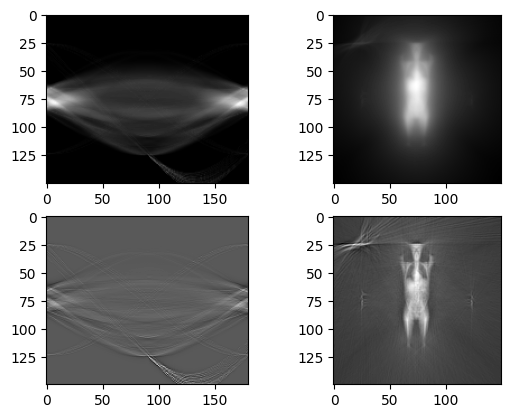

In [85]:

# k1, k2, k3 = generate_kernel(3), generate_kernel(5), generate_kernel(21)

# print(k1, k2, k3, sep="\n")

filtered_sino = filter_sino(sino, generate_kernel(21))
reconstruction = radon_inversed(sino)
reconstruction_filtered = radon_inversed(filtered_sino)

# Image.fromarray(sino).show()
# Image.fromarray(filtered_sino).show()
# Image.fromarray(reconstruction).show()
# Image.fromarray(reconstruction_filtered).show()

plt.subplot(221)
plt.imshow(sino, cmap='gray')
plt.subplot(223)
plt.imshow(filtered_sino, cmap='gray')
plt.subplot(222)
plt.imshow(reconstruction, cmap='gray')
plt.subplot(224)
plt.imshow(reconstruction_filtered, cmap='gray')
plt.show()

    